In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [5]:
# Figure size 8 by 5
plt.figure(figsize=(8,5))

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

In [6]:
# how many time steps/data pts are in one batch of data
seq_length = 20

In [7]:
# generate evenly spaced data pts
time_steps = np.linspace(start = 0, stop = np.pi, num = seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length+1,1))

In [9]:
# define x and y
x = data[:-1]
y = data[1:]

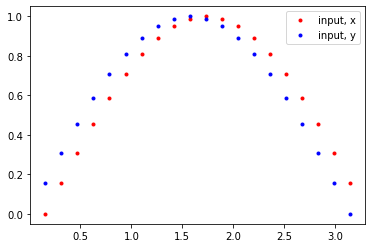

In [12]:
#display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x')
plt.plot(time_steps[1:], y, 'b.', label='input, y')
plt.legend(loc = 'best')
plt.show()

In [13]:
class RNN(nn.Module):
    def __init__(self,input_size,output_size,hidden_dim,n_layers):
        super(RNN,self).__init__()
        
        # store hidden_dim to be used later
        self.hidden_dim = hidden_dim
        
        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first = True)

        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
        
        
    def forward(self,x,hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x,hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1,self.hidden_dim)
        
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden
        
        

In [20]:
# test that dimensions are as expected
test_rnn = RNN(input_size = 1,output_size = 1,hidden_dim = 10,n_layers = 2)

# generate evenly spaced, test data pts
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))

test_input = torch.Tensor(data).unsqueeze(0)
print('Input size: ', test_input.size())

test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 20, 1])
Output size:  torch.Size([20, 1])
Hidden state size:  torch.Size([2, 1, 10])


In [21]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_dim=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [22]:
# loss criterion and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

In [25]:
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None
    
    # for loop
    for step in range(n_steps):
        
        # generate data on the fly
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length+1,1))
        x = data[:-1]
        y = data[1:]
        
        x_tensor = torch.Tensor(x).unsqueeze(0)
        y_tensor = torch.Tensor(y)
        
        # forward pass
        prediction, hidden = rnn(x_tensor, hidden)
        hidden = hidden.data # detach from last step so we don't backpropagate through all history
        
        # loss
        loss = criterion(prediction, y_tensor)
        
        # clean gradients
        optimizer.zero_grad()
        
        # backpropagation
        loss.backward()
        
        # take a step
        optimizer.step()
        
        # display loss and predictions
        if step%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.') # input
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
    
    # return model
    return rnn
    

Loss:  0.6707170605659485


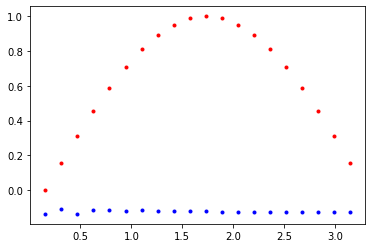

Loss:  0.01318570226430893


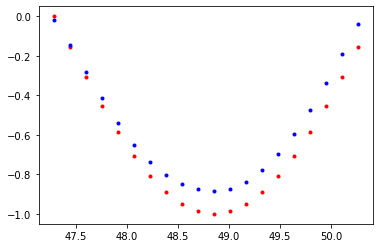

Loss:  0.007119699381291866


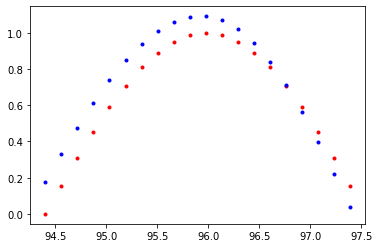

Loss:  0.0009068635408766568


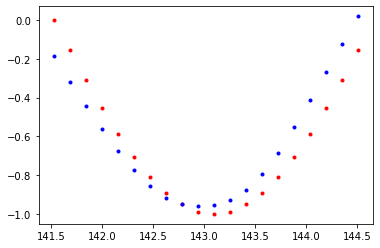

Loss:  0.0003182575455866754


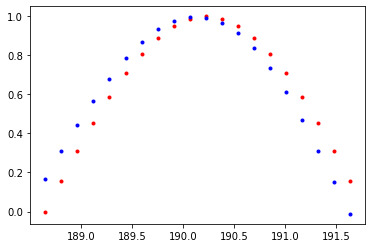

In [26]:
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)